In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from peft import get_peft_model, LoraConfig, TaskType


In [2]:
# GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
# Load data
df = pd.read_csv('CategoryClasification.csv')


In [5]:
# Encode labels
labels = sorted(df['Label'].unique())
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for label, idx in label2id.items()}
df['Label'] = df['Label'].map(label2id)


In [6]:
# Split into train and test sets ..20% testing data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Query'], df['Label'], test_size=0.2, random_state=42
)


In [7]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [8]:
# Dataset class
class QueryDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        inputs = tokenizer(
            text, padding="max_length", max_length=128, truncation=True, return_tensors="pt"
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }


In [9]:
# Prepare datasets and dataloaders
train_dataset = QueryDataset(train_texts, train_labels)
val_dataset = QueryDataset(val_texts, val_labels)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)


In [10]:
# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=len(labels)
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# PEFT: Add LoRA adapters for parameter-efficient fine-tuning
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)
model.to(device)

PeftModel(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768

In [13]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [14]:
# Training loop
epochs = 5
train_loss_history = []
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_dataloader)
    train_loss_history.append(avg_loss)  # Save the average loss for this epoch
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {avg_loss:.4f}")


Epoch 1/5, Training Loss: 2.9951
Epoch 2/5, Training Loss: 2.5172
Epoch 3/5, Training Loss: 2.1153
Epoch 4/5, Training Loss: 1.8550
Epoch 5/5, Training Loss: 1.6780


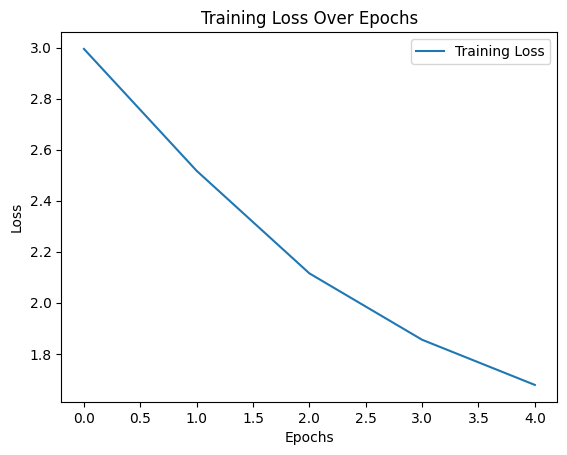

In [15]:
# Plot the training loss over epochs
plt.plot(range(epochs), train_loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


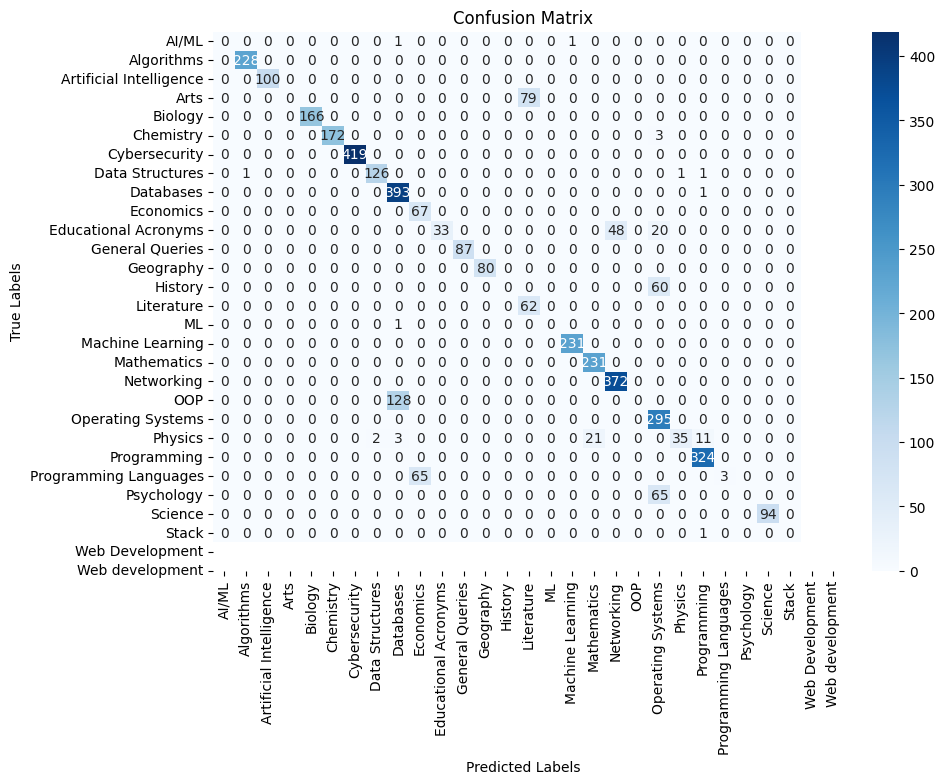

In [18]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to hold predictions and true labels
preds, true_labels = [], []

# Disable gradient calculations to save memory and computations
with torch.no_grad():
    for batch in val_dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)


        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits


        pred = torch.argmax(logits, axis=1)


        preds.extend(pred.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(true_labels, preds)

# Visualize the confusion matrix with a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[id2label[i] for i in range(len(id2label))],
            yticklabels=[id2label[i] for i in range(len(id2label))])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [17]:
# Save the model
model.save_pretrained("trained_bert_lora_model")
tokenizer.save_pretrained("trained_bert_lora_model")


('trained_bert_lora_model/tokenizer_config.json',
 'trained_bert_lora_model/special_tokens_map.json',
 'trained_bert_lora_model/vocab.txt',
 'trained_bert_lora_model/added_tokens.json')